En esta práctica, llevaremos a cabo un análisis de sentimientos utilizando un modelo transformer ajustado mediante fine-tuning. Para ello, partiremos de un modelo transformer previamente entrenado, al que adaptaremos su capa de salida para que se ajuste a nuestra tarea de clasificación de sentimientos.

El modelo que utilizaremos es BERT, un transformer preentrenado que nos proporciona herramientas integradas, como la tokenización automática del texto.

El conjunto de datos empleado será el mismo que en la primera práctica: comentarios extraídos de la red social Twitter, clasificados en tres categorías: "positivo", "negativo" y "neutral". Sin embargo, en esta ocasión nos centraremos exclusivamente en la clasificación binaria de comentarios "positivos" y "negativos".

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
df = pd.read_csv("Tweets.csv", delimiter=',')

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Procedemos a quedarnos con las columnas de "text" y de "airline_sentiment", que son las que nos van a interesar para este problema

In [ ]:
dataset = df[["text", "airline_sentiment"]]
dataset.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


Una vez ya tenemos nuestro dataset, vamos a entender un poco el dataset. Para ello, vamos a representar las salidas mediante un diagrama de barras.

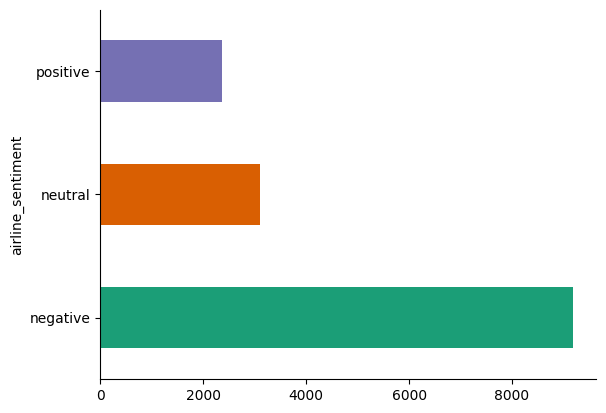

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
dataset.groupby('airline_sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# eliminamos las casillas donde el valor resultado sea "neutral"
dataset = dataset[dataset["airline_sentiment"] != "neutral"]
print(dataset.head())
posibles_resultados = dataset["airline_sentiment"].unique()
print(f"Posibles resultados: {posibles_resultados}")

# Convertimos la columna que tiene los resultados a formato numérico
label_mapping = {
    "positive": 1,
    "negative": 0
}

# Aplicamos el mapeo
dataset["airline_sentiment"] = dataset["airline_sentiment"].map(label_mapping)
print(dataset.head())

                                                text airline_sentiment
1  @VirginAmerica plus you've added commercials t...          positive
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative
5  @VirginAmerica seriously would pay $30 a fligh...          negative
6  @VirginAmerica yes, nearly every time I fly VX...          positive
Posibles resultados: ['positive' 'negative']
                                                text  airline_sentiment
1  @VirginAmerica plus you've added commercials t...                  1
3  @VirginAmerica it's really aggressive to blast...                  0
4  @VirginAmerica and it's a really big bad thing...                  0
5  @VirginAmerica seriously would pay $30 a fligh...                  0
6  @VirginAmerica yes, nearly every time I fly VX...                  1


<ipython-input-9-c33ce2a4ec69>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["airline_sentiment"] = dataset["airline_sentiment"].map(label_mapping)


Dado que vamos a utilizar un modelo transformer, debemos adaptar nuestra entrada al formato que BERT (el modelo que emplearemos) requiere para poder procesarla. En concreto, la entrada debe tener la siguiente estructura:

[CLS] texto [SEP]

El token [CLS] se utiliza al inicio de cada entrada y representa el embedding de clasificación que usará BERT para generar la predicción final. El token [SEP] se coloca al final y sirve para indicar la separación entre frases o el final de la secuencia.

Una vez estructurado el texto, es necesario tokenizarlo, es decir, convertirlo en números que el modelo pueda entender. Las redes neuronales no pueden trabajar directamente con texto, por lo que este paso transforma cada palabra o subpalabra en un identificador numérico según el vocabulario del modelo.

In [ ]:
# dividimos el dataset en conjunto de entrada (x) y conjunto de salida (y)
x = dataset["text"].values
y = dataset["airline_sentiment"].values

# convertimos al formato de entrada que necesita BERT para su tokenización
input_formateado = []
for palabra in x:
  input_formateado.append("[CLS] "+palabra+" [SEP]")

print(input_formateado[0])

[CLS] @VirginAmerica plus you've added commercials to the experience... tacky. [SEP]


In [ ]:
# procedemos a tokenizar nuestra entrada ya ajustada
tokenizador = BertTokenizer.from_pretrained("bert-base-uncased")

input_tokenizado = []

for entrada in input_formateado:
  entrada = entrada.lower()
  input_tokenizado.append(tokenizador.tokenize(entrada))

print(input_tokenizado[0])

['[', 'cl', '##s', ']', '@', 'virgin', '##ame', '##rica', 'plus', 'you', "'", 've', 'added', 'commercials', 'to', 'the', 'experience', '.', '.', '.', 'tack', '##y', '.', '[', 'sep', ']']


La entrada en el modelo BERT debe de estar en un determinado formato:
   - Input_ids: es un id que recibe cada palabra.
   - Máscara de segmento: nos dice si la entrada tiene una o dos oraciones, es decir, por ejemplo si viene pregunta y respuesta (contaría como 2).
   - Máscara de atención: hacemos un padding para ajustar y tener un tamaño fijo, vamos a representar con 1s donde hay palabra y con 0s donde no hay. Si la palabra es mayor que el tamaño de la entrada fijado, se hace un truncamiento, por delante o por detras.
   - Etiqueta: la etiqueta es el resultado para esa entrada.

   Hacemos un padding para que la entrada siempre sea del mismo tamaño. Como estamos tratanto con textos de distinta longitud, vamos a establecer un tamaño máximo, de esta manera, todo lo que sea menor a este tamaño, se pondrá con 0s mientras que toda entrada que sea mayor, se hace un corte, ya sea por delante o por detras

Ya tenemos el texto tokenizado, por lo que procedemos a ajustar la entrada a como la va a recibir el modelo BERT.

In [ ]:
# tamaño maximo de la entrada = 128
max_input_size = 128

# convertimos cada palabra en un id (input_ids)
input_ids = []
for entrada in input_tokenizado:
  input_ids.append(tokenizador.convert_tokens_to_ids(entrada))

# aplicamos el padding para que las entradas tengan el mismo formato
input_padding = []
for entrada in input_ids:
  input_padding.append(pad_sequences([entrada], maxlen=max_input_size, dtype="long", truncating="post", padding="post"))
print("*"*40+"\n"+ "Example PADDING")
print(input_padding[0])

# preparamos el input padding
input_padding_prepared = []
for entrada in input_padding:
  input_padding_prepared.append(entrada[0])
print("*"*40+"\n"+ "Example PADDING bueno")
print(input_padding_prepared[0])

# creamos la mascara de atencion (1.0=hay algo, 0=nada)
input_mascara = []
for entrada in input_padding:
  line_mask = []
  for numero in entrada[0]:
    if numero > 0:
      line_mask.append(1.0)
    else:
      line_mask.append(0.0)
  input_mascara.append(line_mask)

print("*"*40+"\n"+ "Example MASK")
print(input_mascara[0])


****************************************
Example PADDING
[[ 1031 18856  2015  1033  1030  6261 14074 14735  4606  2017  1005  2310
   2794 12698  2000  1996  3325  1012  1012  1012 26997  2100  1012  1031
  19802  1033     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
****************************************
Example PADDING bueno
[ 1031 18856  2015  1033  1030  6261 14074 14735  4606  2017  1005  2310
  2794 12698  2

Ahora procedemos a dividir el dataset en conjunto de entrenamiento y de test. Para ello, dividiremos tanto el conjunto de padding como el conjunto de la mascara de atención.

In [ ]:
# dividimos el conjunto de padding
input_train_padding, input_test_padding, output_train_padding, output_test_padding = train_test_split(input_padding_prepared, y, test_size=0.2, random_state=42)

# dividimos el conjunto de mascaras
input_train_mascara, input_test_mascara, _, _ = train_test_split(input_mascara, y, test_size=0.2, random_state=42)

print(input_train_padding[0])
print(output_train_padding)

[ 1031 18856  2015  1033  1030  3915  4313 14035  2178  2757  2203  1012
  2027  2069  5047  9779  1048  1004 23713  1025  1042  1012  2027  2435
  2033  1996  2168  3478  1001  1045  2525  2018  1012 19827  1011  4029
  2475  1011  6356  2683  2620  1006  5585  1007  1058  2213  2440  1012
  1001  2439  1031 19802  1033     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[0 0 0 ... 1 0 0]


Ahora convertimos los conjuntos de datos en el formato que acepta pytorch. Además, vamos a definir la entrada que recibirá nuestro transformer BERT.

In [ ]:
# preparamos los datos con el formato de pytorch
input_train_padding = torch.tensor(input_train_padding)
input_test_padding = torch.tensor(input_test_padding)
output_train_padding = torch.tensor(output_train_padding)
output_test_padding = torch.tensor(output_test_padding)
input_train_mascara = torch.tensor(input_train_mascara)
input_test_mascara = torch.tensor(input_test_mascara)

<ipython-input-14-5de2651a4355>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  input_train_padding = torch.tensor(input_train_padding)


In [ ]:
# fijamos el tamaño del batch
batch_size = 32

# creamos un conjunto de datos de entrada para entrenamiento
train_data = TensorDataset(input_train_padding, input_train_mascara, output_train_padding)
# creamos un seleccionador aleatorio de muestras
train_sampler = RandomSampler(train_data)
# creamos un objeto que va cargando los datos al entrenamiento
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# creamos conjunto de datos de entrada para el test
test_data = TensorDataset(input_test_padding, input_test_mascara, output_test_padding)
# creamos el seleccionador de muestras aleatorio
test_sampler = SequentialSampler(test_data)
# creamos el cargador de datos en el entrenamiento
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Ya tenemos todo listo. Ahora solo nos falta definir el modelo BERT configurado para fine-tuning, es decir, añadir una pequeña red neuronal encima del transformador. Esta capa adicional ajustará sus pesos durante el entrenamiento para ofrecer la salida que buscamos: la clasificación de sentimientos.

In [ ]:
# Cargamos BertForSequenceClassification, que es un modelo BERT ya preentrenado, con una simple capa final para clasificar

modelo = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
modelo.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=Fa

Preparamos los distintos hiperparámetros que vamos a usar, en donde, el modelo se quedará con el mejor.

In [ ]:
'''
param_optimizer = list(modelo.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
'''
optimizador = BertAdam(modelo.parameters(),
                     lr=2e-5,
                     warmup=.1)



Para el entrenamiento y la validación, utilizaremos el código proporcionado por el profesor durante las clases.

In [ ]:
# funcion que calcula el accuracy de nuestras predicciones vs valor real
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  modelo.train()
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  for step, batch in enumerate(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    optimizador.zero_grad()

    loss = modelo(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())

    loss.backward()
    optimizador.step()

    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {:.4f}".format(tr_loss / nb_tr_steps))

  # Validation
  modelo.eval()
  eval_accuracy = 0
  nb_eval_steps = 0

  all_preds = []
  all_labels = []

  for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = modelo(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = outputs.logits if hasattr(outputs, 'logits') else outputs

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

    preds = np.argmax(logits, axis=1).flatten()
    labels = label_ids.flatten()
    all_preds.extend(preds)
    all_labels.extend(labels)

  print("Validation Accuracy: {:.4f}".format(eval_accuracy / nb_eval_steps))

  # Classification report
  print("\nClassification Report:")
  print(classification_report(all_labels, all_preds, target_names=["negativo", "positivo"]))


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Train loss: 0.2375


Epoch:  50%|█████     | 1/2 [04:07<04:07, 247.02s/it]

Validation Accuracy: 0.9360

Classification Report:
              precision    recall  f1-score   support

    negativo       0.96      0.97      0.96      1862
    positivo       0.85      0.82      0.84       447

    accuracy                           0.94      2309
   macro avg       0.91      0.89      0.90      2309
weighted avg       0.94      0.94      0.94      2309

Train loss: 0.1254


Epoch: 100%|██████████| 2/2 [08:16<00:00, 248.20s/it]

Validation Accuracy: 0.9348

Classification Report:
              precision    recall  f1-score   support

    negativo       0.96      0.96      0.96      1862
    positivo       0.83      0.85      0.84       447

    accuracy                           0.94      2309
   macro avg       0.90      0.90      0.90      2309
weighted avg       0.94      0.94      0.94      2309



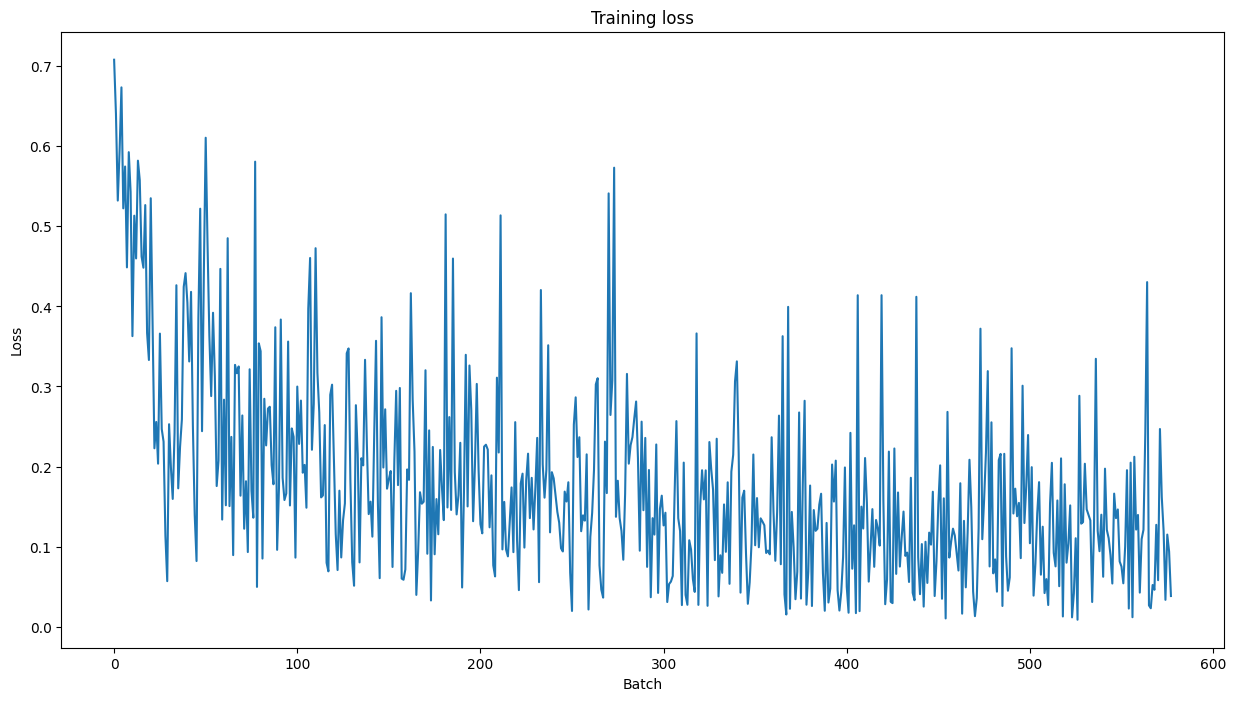

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Calculamos la matriz de confusión y a través de ella, calcularemos el resto de métricas para ver como de bien está fine-tuneado nuestro modelo.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz_confusion = confusion_matrix(all_labels, all_preds)
print(matriz_confusion)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negativo", "positivo"]))


[[1783   79]
 [  68  379]]

Classification Report:
              precision    recall  f1-score   support

    negativo       0.96      0.96      0.96      1862
    positivo       0.83      0.85      0.84       447

    accuracy                           0.94      2309
   macro avg       0.90      0.90      0.90      2309
weighted avg       0.94      0.94      0.94      2309

